##TEAM MEMBERS:

* Esther Apaza
* Franchisco Chan
* Carlos Helguera
* Rogelio Novelo
* Valeria Ramirez
* Daniel Valdes

In [ ]:
!pip install pycountry
!pip install pycountry_convert
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.6/250.6 kB 7.6 MB/s eta 0:00:00


## **Treemap**

In [ ]:
import re
import pandas as pd
import pycountry
import pycountry_convert as pc

# Cargar dataset
df = pd.read_csv("population.csv")

In [ ]:
INPUT = "population.csv"
OUTPUT = "countries_per_region.csv"

# Mantener América del Norte y América del Sur separadas
CONTINENT_CODE_TO_NAME = {
    'AF': 'Africa',
    'AS': 'Asia',
    'EU': 'Europe',
    'OC': 'Oceania',
    'NA': 'North America',
    'SA': 'South America',
}

# Overrides para territorios que a veces fallan
ALPHA2_CONTINENT_OVERRIDES = {
    'XK': 'EU',  # Kosovo
    'CW': 'NA',  # Curaçao
    'SX': 'NA',  # Sint Maarten
    'BQ': 'NA',  # Bonaire, Sint Eustatius and Saba
    'GG': 'EU',  # Guernsey
    'JE': 'EU',  # Jersey
    'IM': 'EU',  # Isle of Man
    'HK': 'AS',  # Hong Kong
    'MO': 'AS',  # Macao
    'PS': 'AS',  # State of Palestine
    'TW': 'AS',  # Taiwan
}

def clean_code(raw):
    if pd.isna(raw):
        return None
    s = str(raw).strip().upper()
    # quita guiones, guiones bajos, espacios u otros símbolos
    s = re.sub(r'[^A-Z]', '', s)
    return s or None

def to_alpha2(code):
    if code is None:
        return None
    if len(code) == 2:
        return code
    if len(code) == 3:
        country = pycountry.countries.get(alpha_3=code)
        if country:
            return country.alpha_2
    return None

def alpha2_to_continent_name(alpha2):
    if alpha2 is None:
        return 'Unknown'
    if alpha2 in ALPHA2_CONTINENT_OVERRIDES:
        cont_code = ALPHA2_CONTINENT_OVERRIDES[alpha2]
        return CONTINENT_CODE_TO_NAME.get(cont_code, 'Unknown')
    try:
        cont_code = pc.country_alpha2_to_continent_code(alpha2)
        return CONTINENT_CODE_TO_NAME.get(cont_code, 'Unknown')
    except Exception:
        return 'Unknown'

# --- Pipeline ---
df = pd.read_csv(INPUT)

# Ajusta si tu columna se llama distinto
CODE_COL = 'Country_Code'
NAME_COL = 'Country_Name'

cleaned = df[CODE_COL].apply(clean_code)
alpha2 = cleaned.apply(to_alpha2)
df['Continent'] = alpha2.apply(alpha2_to_continent_name)

# Guarda CSV
df.to_csv(OUTPUT, index=False, encoding='utf-8')

print(f"✅ Archivo '{OUTPUT}' generado.")
unknown = df[df['Continent'] == 'Unknown'][[NAME_COL, CODE_COL]].head(20)
if not unknown.empty:
    print("⚠️ Ejemplos que quedaron 'Unknown' (muestra):")
    print(unknown.to_string(index=False))


✅ Archivo 'countries_per_region.csv' generado.
⚠️ Ejemplos que quedaron 'Unknown' (muestra):
Country_Name Country_Code
 Timor-Leste           TL


In [ ]:
df2 = pd.read_csv("countries_per_region.csv")
df2.head()

,Country_Name,Country_Code,Population,GDP,Continent
0,Afghanistan,AFG,42647492,0.00000,Asia
1,Angola,AGO,37885849,2122.08369,Africa
2,Albania,ALB,2714617,10011.62799,Europe
3,Andorra,AND,81938,49303.67339,Europe
4,United Arab Emirates,ARE,10876981,49377.56434,Asia


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "colab"

# --- Load ---
df = pd.read_csv("countries_per_region.csv")

# Tipos numéricos
df["Population"] = pd.to_numeric(df["Population"], errors="coerce")
df["GDP"] = pd.to_numeric(df["GDP"], errors="coerce")
df = df.dropna(subset=["Population", "GDP", "Continent", "Country_Name"])
df = df[df["Population"] > 0].copy()

# Colores pastel
PASTEL_SCALE = [
    [0.00, "#e7f0ff"],
    [0.20, "#dfeef6"],
    [0.40, "#d7e9ef"],
    [0.60, "#cfe4e8"],
    [0.75, "#c6dfdf"],
    [0.88, "#bdd9d7"],
    [1.00, "#b3d3cf"],
]

df["Population_adj"] = df["Population"] ** 0.72
med_gdp = df["GDP"].replace(0, np.nan).median()
df["GDP"] = df["GDP"].replace(0, np.nan).fillna(med_gdp)

def treemap_trace(data, parent_label):
    fig_tmp = px.treemap(
        data,
        path=["ContinentView", "Country_Name"],
        values="Population_adj",
        color="GDP",
        height=700,
        width=900,
        color_continuous_scale=PASTEL_SCALE,
        hover_data={"Country_Code": True, "Population": ":,", "GDP": ":,.2f"},
    )
    tr = fig_tmp.data[0]
    tr.name = parent_label
    tr.visible = False
    tr.textinfo = "label"
    tr.textfont = dict(size=12)
    tr.tiling = dict(pad=2, packing="squarify")
    return tr

traces = []

# --- Regiones ---
america = df[df["Continent"].isin(["North America", "South America"])].copy()
america["ContinentView"] = "America"
traces.append(treemap_trace(america, "America (NA+SA)"))

africa = df[df["Continent"] == "Africa"].copy()
africa["ContinentView"] = "Africa"
traces.append(treemap_trace(africa, "Africa"))

asia = df[df["Continent"] == "Asia"].copy()
asia["ContinentView"] = "Asia"
traces.append(treemap_trace(asia, "Asia"))

europe = df[df["Continent"] == "Europe"].copy()
europe["ContinentView"] = "Europe"
traces.append(treemap_trace(europe, "Europe"))

oceania = df[df["Continent"] == "Oceania"].copy()
oceania["ContinentView"] = "Oceania"
traces.append(treemap_trace(oceania, "Oceania"))

# --- Vista agregada ---
agg = df.groupby("Continent", as_index=False).agg(
    Population=("Population", "sum"), GDP=("GDP", "median")
)
fig_tmp_agg = px.treemap(
    agg,
    path=["Continent"],
    values="Population",
    color="GDP",
    color_continuous_scale=PASTEL_SCALE,
    hover_data={"Population": ":,", "GDP": ":,.2f"},
)
tr_agg = fig_tmp_agg.data[0]
tr_agg.name = "All Continents"
tr_agg.visible = False
traces.append(tr_agg)

# --- Figura con dropdown ---
fig = go.Figure(traces)
for i, _ in enumerate(fig.data):
    fig.data[i].visible = (i == 0)

labels = [
    "North and South America",
    "Africa",
    "Asia",
    "Europe",
    "Oceania",
    "All Continents ",
]

buttons = []
for i, label in enumerate(labels):
    vis = [False] * len(traces)
    vis[i] = True
    buttons.append(
        dict(
            method="update",
            label=label,
            args=[
                {"visible": vis},
                {"title": {"text": "World Population Analysis"}},
            ],
        )
    )

# --- Layout limpio ---
fig.update_layout(
    margin=dict(t=160, l=10, r=10, b=10),
    title=dict(
        text="World Population Analysis",
        y=0.96,
        x=0.5,
        xanchor="center",
        yanchor="top",
        font=dict(size=22, color="#1f2a44"),
    ),
    updatemenus=[
        dict(
            type="dropdown",
            direction="down",
            x=0,
            y=1.15,
            xanchor="center",
            yanchor="top",
            showactive=True,
            buttons=buttons,
        )
    ],
    coloraxis_colorbar=dict(title="GDP per capita"),
    uniformtext=dict(minsize=11, mode="show"),
)

fig.show()


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "colab"

# --- Load ---
df = pd.read_csv("countries_per_region.csv")

# Tipos numéricos
df["Population"] = pd.to_numeric(df["Population"], errors="coerce")
df["GDP"] = pd.to_numeric(df["GDP"], errors="coerce")

df = df.dropna(subset=["Population", "GDP", "Continent", "Country_Name", "Country_Code"])
df = df[df["Population"] > 0].copy()

# Colores pastel
PASTEL_SCALE = [
    [0.00, "#e7f0ff"],
    [0.20, "#dfeef6"],
    [0.40, "#d7e9ef"],
    [0.60, "#cfe4e8"],
    [0.75, "#c6dfdf"],
    [0.88, "#bdd9d7"],
    [1.00, "#b3d3cf"],
]

df["Population_adj"] = df["Population"] ** 0.72
med_gdp = df["GDP"].replace(0, np.nan).median()
df["GDP"] = df["GDP"].replace(0, np.nan).fillna(med_gdp)

def treemap_trace(data, parent_label):
    # Usamos Country_Code directamente en el treemap
    data["Country_Label"] = data["Country_Code"]

    fig_tmp = px.treemap(
        data,
        path=["ContinentView", "Country_Label"],
        values="Population_adj",
        color="GDP",
        height=900,
        width=2000,
        color_continuous_scale=PASTEL_SCALE,
        hover_data={"Country_Code": True, "Population": ":,", "GDP": ":,.2f"},
    )

    tr = fig_tmp.data[0]
    tr.name = parent_label
    tr.visible = False
    tr.textinfo = "label"
    tr.textfont = dict(size=12)
    tr.tiling = dict(pad=2, packing="squarify")
    return tr

traces = []

# --- Función para Top 10 y generar texto de leyenda ---

def get_top_10(data, continent_view):
    # 1. Filtrado de Top 10
    top_10 = data.sort_values(by="Population", ascending=False).head(10).copy()
    top_10["ContinentView"] = continent_view

    # 2. Generación del texto de leyenda
    legend_text = "<b>Code: Country:</b><br>"
    for index, row in top_10.iterrows():
        legend_text += f"{row['Country_Code']}: {row['Country_Name']}<br>"

    return top_10, legend_text

# Diccionario para guardar el texto de leyenda para cada continente
legend_texts = {}

# --- Preparación de Datos (Top 10 para cada región) ---

# América (Norte y Sur)
america_full = df[df["Continent"].isin(["North America", "South America"])].copy()
america, legend_texts["America"] = get_top_10(america_full, "America")
traces.append(treemap_trace(america, "America (NA+SA)"))

# África
africa_full = df[df["Continent"] == "Africa"].copy()
africa, legend_texts["Africa"] = get_top_10(africa_full, "Africa")
traces.append(treemap_trace(africa, "Africa"))

# Asia
asia_full = df[df["Continent"] == "Asia"].copy()
asia, legend_texts["Asia"] = get_top_10(asia_full, "Asia")
traces.append(treemap_trace(asia, "Asia"))

# Europa
europe_full = df[df["Continent"] == "Europe"].copy()
europe, legend_texts["Europe"] = get_top_10(europe_full, "Europe")
traces.append(treemap_trace(europe, "Europe"))

# Oceanía
oceania_full = df[df["Continent"] == "Oceania"].copy()
oceania, legend_texts["Oceania"] = get_top_10(oceania_full, "Oceania")
traces.append(treemap_trace(oceania, "Oceania"))

# --- Vista agregada (sin leyenda de códigos) ---
agg = df.groupby("Continent", as_index=False).agg(
    Population=("Population", "sum"), GDP=("GDP", "median")
)
fig_tmp_agg = px.treemap(
    agg,
    path=["Continent"],
    values="Population",
    color="GDP",
    color_continuous_scale=PASTEL_SCALE,
    hover_data={"Population": ":,", "GDP": ":,.2f"},
)
tr_agg = fig_tmp_agg.data[0]
tr_agg.name = "All Continents (Aggregated)"
tr_agg.visible = False
traces.append(tr_agg)

# Leyenda para la vista agregada (sin códigos de país)


# --- Figura con dropdown ---
fig = go.Figure(traces)
for i, _ in enumerate(fig.data):
    fig.data[i].visible = (i == 0)

labels = [
    "North and South America",
    "Africa",
    "Asia",
    "Europe",
    "Oceania",
    "All Continents",
]

# ⚠️ CORRECCIÓN: Lista de textos de leyenda en el orden de los traces
legend_list = [
    legend_texts["America"],
    legend_texts["Africa"],
    legend_texts["Asia"],
    legend_texts["Europe"],
    legend_texts["Oceania"],
    "All Continents "
]

buttons = []
for i, label in enumerate(labels):
    vis = [False] * len(traces)
    vis[i] = True
    buttons.append(
        dict(
            method="update",
            label=label,
            args=[
                {"visible": vis},
                {
                    "title": {"text": "Top 10 countries per continent with the highest population/GDP ratio"},
                    "annotations[0].text": legend_list[i],
                }
            ],
        )
    )

# --- Layout y Anotación Inicial (Leyenda) ---

# Añadir la anotación para la lista de códigos (Leyenda)
fig.add_annotation(
    text=legend_texts["America"], # Texto inicial (para América)
    xref="paper", yref="paper",
    x=-0.11, y=0.5, # Posición en el lado izquierdo del gráfico
    showarrow=False,
    align="left",
    font=dict(size=10, color="#1f2a44"),
    bgcolor="rgba(255, 255, 255, 0.8)",
)

fig.update_layout(
    margin=dict(t=160, l=10, r=10, b=10),
    title=dict(
        text="Top 10 countries per continent with the highest population/GDP ratio",
        y=0.96,
        x=0.5,
        xanchor="center",
        yanchor="top",
        font=dict(size=22, color="#1f2a44"),
    ),
    updatemenus=[
        dict(
            type="dropdown",
            direction="down",
            x=0,
            y=1.15,
            xanchor="center",
            yanchor="top",
            showactive=True,
            buttons=buttons,
        )
    ],
    coloraxis_colorbar=dict(title="GDP per capita"),
    uniformtext=dict(minsize=11, mode="show"),
)

fig.show()

## Dendrogram

In [ ]:

import pandas as pd
import numpy as np
from pathlib import Path
from textwrap import shorten

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.cluster.hierarchy import dendrogram, linkage, optimal_leaf_ordering
import matplotlib.pyplot as plt


In [ ]:

def resolve_csv_path(filename: str = "countries_per_region.csv") -> Path:
    """
    Try to locate the CSV relative to where this .ipynb/.py lives (if __file__ exists).
    Fallbacks:
      1) current working directory (e.g., when running in Jupyter),
      2) /mnt/data (common in hosted notebooks).
    """
    try:
        base = Path(__file__).parent  # when running as a .py script
    except NameError:
        base = Path.cwd()             # in Jupyter there's no __file__

    candidates = [
        base / filename,
        Path.cwd() / filename,
        Path("/mnt/data") / filename,
    ]
    for p in candidates:
        if p.exists():
            return p
    return candidates[0]  # not found; return first candidate to surface a clear error later


In [ ]:

# Load CSV from the resolved path
csv_path = resolve_csv_path("countries_per_region.csv")
print("Using CSV:", csv_path)
df = pd.read_csv(csv_path)

# Ensure numeric types if present
for col in ["Population", "GDP"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.head(5)


Using CSV: /content/countries_per_region.csv


,Country_Name,Country_Code,Population,GDP,Continent
0,Afghanistan,AFG,42647492,0.00000,Asia
1,Angola,AGO,37885849,2122.08369,Africa
2,Albania,ALB,2714617,10011.62799,Europe
3,Andorra,AND,81938,49303.67339,Europe
4,United Arab Emirates,ARE,10876981,49377.56434,Asia


In [ ]:

def detect_column(df: pd.DataFrame, candidates, fallback=None):
    """Case-insensitive detector: returns first column containing any candidate substring."""
    cols_lower = {c.lower(): c for c in df.columns}
    candidates = [c.lower() for c in candidates]
    for key, original in cols_lower.items():
        if any(sub in key for sub in candidates):
            return original
    return fallback


In [ ]:

def plot_country_dendrogram_readable(
    data: pd.DataFrame,
    country_col: str,
    pop_col: str,
    gdp_pc_col: str,
    region_col: str | None = None,
    region_filter: str | None = None,
    label_col: str | None = None,      # e.g., 'Country_Name' or 'Country_Code'
    max_label_chars: int | None = 30,  # None = no truncation
    method: str = "ward",
    metric: str = "euclidean",
    optimal_order: bool = True,        # reorder leaves for clearer view
    orientation: str = "right",        # horizontal labels
    figsize: tuple = (16, 22),         # large figure for readability
    auto_truncate_threshold: int | None = None,  # None = no automatic truncation
    label_pad: int = 16,               # extra space between tree and labels
    leaf_margin: float = 0.03          # extra margin between leaves (0..1)
):
    df = data.copy()

    # Optional region filter
    if region_col and region_filter:
        df = df[df[region_col] == region_filter].copy()
        if df.empty:
            raise ValueError(f"No data for region: {region_filter}")
        title_suffix = f" — Region: {region_filter}"
    else:
        title_suffix = ""

    # Basic validation
    for c in [country_col, pop_col, gdp_pc_col]:
        if c not in df.columns:
            raise ValueError(f"Column not found: {c}")
    if label_col is not None and label_col not in df.columns:
        raise ValueError(f"Label column not found: {label_col}")

    # Ensure numeric and drop rows without the essentials
    df[pop_col] = pd.to_numeric(df[pop_col], errors="coerce")
    df[gdp_pc_col] = pd.to_numeric(df[gdp_pc_col], errors="coerce")
    df = df.dropna(subset=[pop_col, gdp_pc_col, country_col])
    if df.shape[0] < 2:
        raise ValueError("Need at least 2 countries with valid data.")

    X = df[[pop_col, gdp_pc_col]].to_numpy(dtype=float)

    # Impute & standardize (Ward benefits from scaling)
    X_imp = SimpleImputer(strategy="mean").fit_transform(X)
    X_std = StandardScaler().fit_transform(X_imp)

    # Hierarchical linkage (+ optional optimal leaf ordering)
    Z = linkage(X_std, method=method, metric=metric)
    if optimal_order:
        Z = optimal_leaf_ordering(Z, X_std)

    # Labels (country names by default)
    base_labels = df[label_col].astype(str).tolist() if label_col else df[country_col].astype(str).tolist()
    if max_label_chars is not None:
        labels = [shorten(lbl, width=max_label_chars, placeholder="…") for lbl in base_labels]
    else:
        labels = base_labels

    # Optional truncation if too many leaves (disabled by default)
    truncate_mode, p = None, None
    if auto_truncate_threshold is not None and len(labels) > auto_truncate_threshold:
        truncate_mode = "lastp"
        p = int(auto_truncate_threshold)

    # Adaptive font size, with a minimum
    leaf_font_size = max(7, int(18 - 0.05 * len(labels)))

    # Plot (do NOT show leaf counts)
    plt.figure(figsize=figsize)
    kwargs = dict(
        orientation=orientation,
        labels=labels,
        leaf_rotation=0.0 if orientation in ("right", "left") else 90.0,
        leaf_font_size=leaf_font_size,
        truncate_mode=truncate_mode,
        show_leaf_counts=False,
    )
    if p is not None:
        kwargs["p"] = p

    dendrogram(Z, **kwargs)

    # Extra spacing for readability
    ax = plt.gca()
    if orientation in ("right", "left"):
        ax.margins(y=leaf_margin)                # vertical air between leaves
        ax.tick_params(axis="y", pad=label_pad)  # space between tree and labels
        plt.xlabel("Distance")
        plt.ylabel("Country")
    else:
        ax.margins(x=leaf_margin)
        ax.tick_params(axis="x", pad=label_pad)
        plt.xlabel("Country")
        plt.ylabel("Distance")

    plt.title(f"Dendrogram (Ward method){title_suffix}")
    plt.grid(axis="x" if orientation in ("right", "left") else "y")
    plt.tight_layout()
    plt.show()


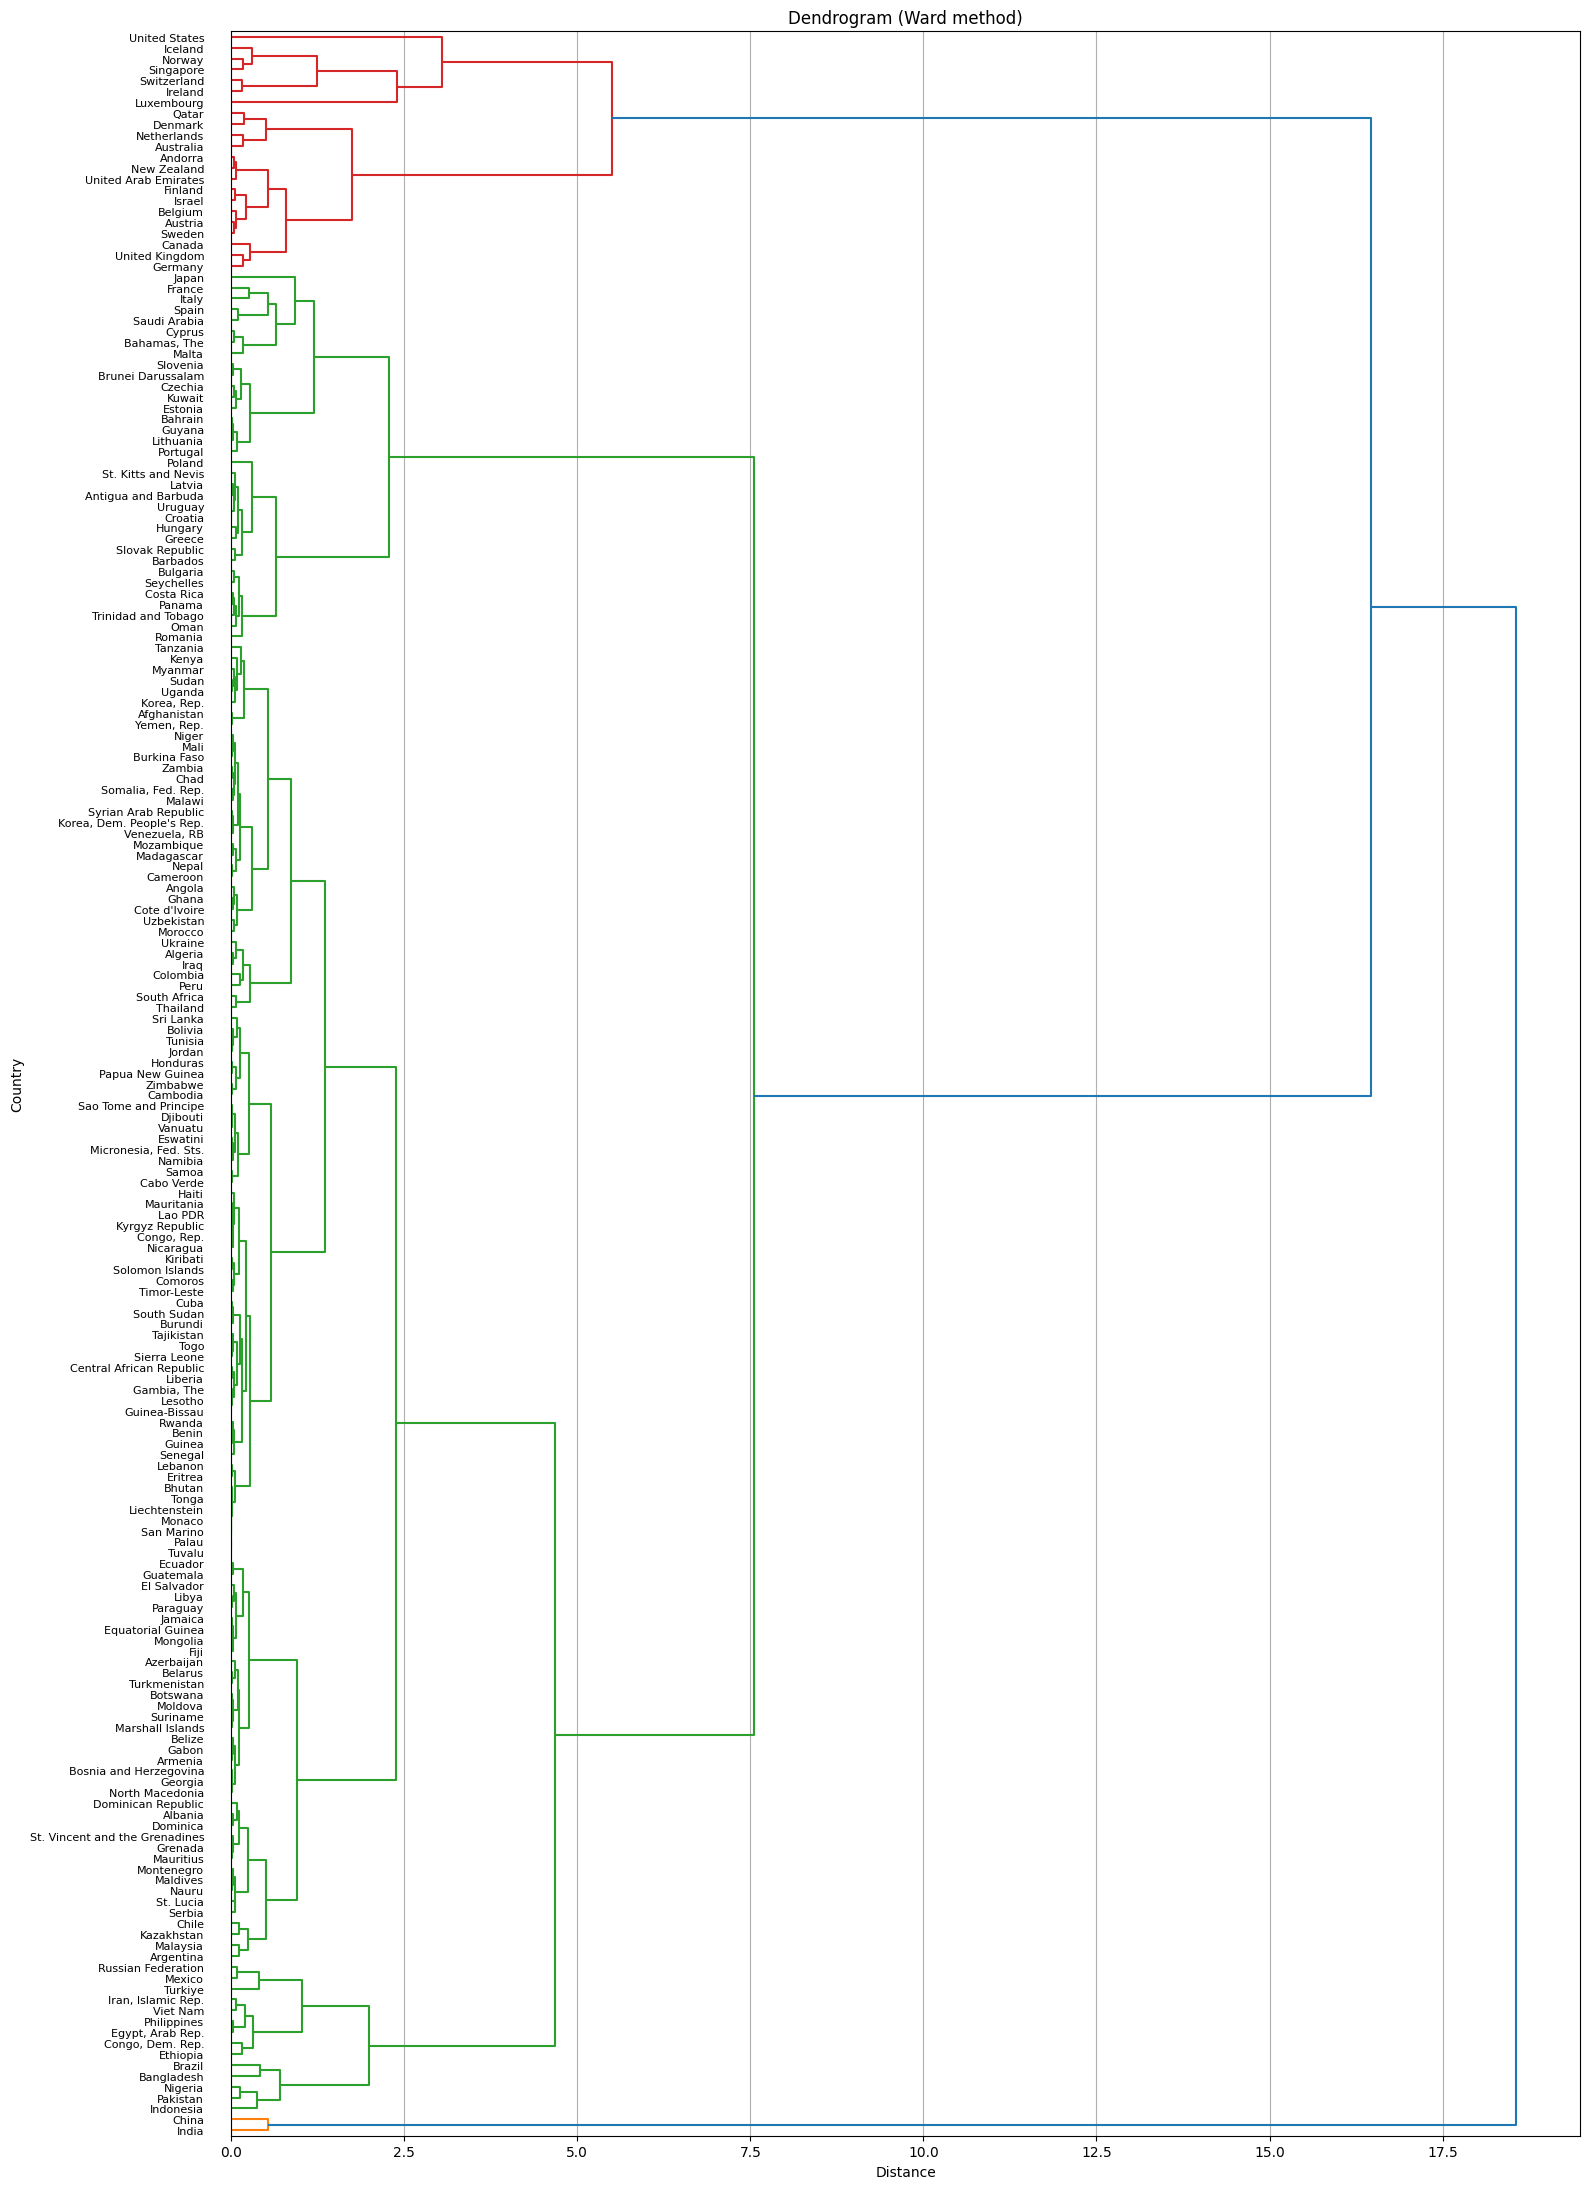

In [ ]:

# Example with CSV structure: Country_Name, Country_Code, Population, GDP, Continent
plot_country_dendrogram_readable(
    data=df,
    country_col="Country_Name",
    pop_col="Population",
    gdp_pc_col="GDP",         # in this CSV, 'GDP' is GDP per capita
    region_col="Continent",
    region_filter=None,
    label_col="Country_Name", # show full names; switch to "Country_Code" for short labels
    max_label_chars=30,
    orientation="right",
    figsize=(16, 22),
    auto_truncate_threshold=None,  # keep all leaves
    label_pad=16,
    leaf_margin=0.03
)


## Sunburst Chart

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

pio.renderers.default = "colab"

# Load
df = pd.read_csv("countries_per_region.csv")



NameError: name 'pio' is not defined

In [ ]:
# Classify economic level according to GDP
def gdp_level(gdp):
    if gdp < 10000:
        return "Low"
    elif gdp < 40000:
        return "Medium"
    else:
        return "High"

df["GDP_Level"] = df["GDP"].apply(gdp_level)

continents = df["Continent"].dropna().unique().tolist()

traces = []
# Generate a sunburst for each continent
for cont in continents:
    filtered = df[df["Continent"] == cont]
    fig_sub = px.sunburst(
        filtered,
        path=["Continent", "Country_Name", "GDP_Level"],
        values="Population",
        color="GDP",
        color_continuous_scale="Viridis",
        title=f"{cont} — Population and GDP Structure"
    )
    traces.append(fig_sub.data[0])

In [ ]:
# Getting the list of continents
continents = df["Continent"].dropna().unique().tolist()

# Creating a lit per continent
traces = []

for cont in continents:
    filtered = df[df["Continent"] == cont]
    fig_sub = px.sunburst(
        filtered,
        path=["Continent", "Country_Name", "GDP_Level"],
        values="Population",
        color="GDP",
        color_continuous_scale="Viridis",
    )

    trace = fig_sub.data[0]
    trace.visible = False
    traces.append(trace)

    # Create main figure
fig = go.Figure(traces)

# Show only the first continent at the beginning
fig.data[0].visible = True

buttons = []
for i, label in enumerate(continents):
    vis = [False] * len(continents)
    vis[i] = True
    buttons.append(
        dict(
            method="update",
            label=label,
            args=[
                {"visible": vis},
                {"title": {"text": f"Sunburst Chart — {label}"}},
            ],
        )
    )

# Add trace of all continents together
fig_all = px.sunburst(
    df,
    path=["Continent", "Country_Name", "GDP_Level"],
    values="Population",
    color="GDP",
    color_continuous_scale="Viridis"
).data[0]
fig.add_trace(fig_all)

vis_all = [False] * len(continents) + [True]
buttons.append(
    dict(
        method="update",
        label="All Continents",
        args=[
            {"visible": vis_all},
            {"title": {"text": "Sunburst Chart — All Continents"}},
        ],
    )
)

In [ ]:
# Clean design with interactive drop-down menu
fig.update_layout(
    title="Sunburst Chart — World Population and GDP by Continent",
     coloraxis_colorbar=dict(
        title="GDP per Capita",  # <-- título de la barra de colores
        titlefont=dict(size=14, family="Arial", color="black"),
    ),
    updatemenus=[
        dict(
            active=0,
            buttons=buttons,
            x=1.15,
            y=0.8,
            xanchor="left",
            yanchor="top"
        )
    ],
    margin=dict(t=70, l=50, r=50, b=50)

)

fig.show()

NameError: name 'fig' is not defined

In [ ]:
# Import Libraries
import pandas as pd
import plotly.graph_objects as go

# CELL 2: Organizational Structure Data - TERRA COTTA FOODS (1000 EMPLOYEES)
# The 'values' have been scaled for a total of 1000 employees.

org_structure = {
    'labels': [
        # Root
        'Terra Cotta Foods',

        # Main Divisions
        'Production', 'Product Development', 'Sales', 'Operations',

        # Departments (Level 2)
        'Food Processing', 'Quality Control', 'Packaging', 'Supply Chain',
        'R&D', 'Market Analytics', 'Procurement',
        'Wholesale', 'Retail', 'Partnerships',
        'Human Resources', 'Finance', 'Legal', 'IT Support',

        # Intermediate Level (Level 3)
        'Infrastructure', # New under IT Support

        # Teams (lowest hierarchy - Level 3 or Level 4)
        'Processing-Team1', 'Processing-Team2', 'QC-Team1', 'QC-Team2',
        'Packaging-UnitA', 'Packaging-UnitB', 'Supply-Logistics', 'Supply-Storage',
        'R&D-Lab', 'R&D-Testing', 'Analytics-Data', 'Analytics-Insights',
        'Procurement-Local', 'Procurement-Global',

        # Legal Teams
        'Legal-Compliance', 'Legal-Contracts',

        # IT Support Teams
        'Help Desk', # Direct team under IT Support
        'Network & Servers', 'Databases' # Teams under Infrastructure
    ],

    'parents': [
        '',  # Root of the Sunburst chart

        # Divisions
        'Terra Cotta Foods', 'Terra Cotta Foods', 'Terra Cotta Foods', 'Terra Cotta Foods',

        # Departments under divisions
        'Production', 'Production', 'Production', 'Production',
        'Product Development', 'Product Development', 'Product Development',
        'Sales', 'Sales', 'Sales',
        'Operations', 'Operations', 'Operations', 'Operations',

        # Intermediate Level
        'IT Support', # Infrastructure reports to IT Support

        # Teams under departments
        'Food Processing', 'Food Processing', 'Quality Control', 'Quality Control',
        'Packaging', 'Packaging', 'Supply Chain', 'Supply Chain',
        'R&D', 'R&D',
        'Market Analytics', 'Market Analytics',
        'Procurement', 'Procurement',

        # Legal Teams
        'Legal', 'Legal',

        # IT Support Teams
        'IT Support', # Help Desk reports to IT Support
        'Infrastructure', 'Infrastructure' # Network/Databases report to Infrastructure
    ],

    'values': [
        1000,    # Total company size
        360, 160, 240, 240,  # Divisions
        # Production (360) subareas
        120, 100, 80, 60,
        # Product Development (160) subareas
        60, 50, 50,
        # Sales (240) subareas
        100, 80, 60,
        # Operations (240) subareas
        65, 60, 50, 65,
        # Infrastructure (Intermediate Level - 40 employees)
        40,
        # Teams - Production (360)
        60, 60, 50, 50,
        40, 40, 30, 30,
        # Teams - R&D / Analytics (110)
        30, 30, 25, 25,
        # Teams - Procurement (50)
        25, 25,
        # Teams - Legal (50)
        25, 25,
        # Teams - IT Support (65)
        25,                  # Help Desk
        20, 20               # Infrastructure Teams
    ]
}

df = pd.DataFrame(org_structure)

In [ ]:
# Show the Sunburst Chart
fig = go.Figure(go.Sunburst(
    labels=df['labels'],
    parents=df['parents'],
    values=df['values'],
    branchvalues="total", # Ensures parent size reflects the sum of its children
    marker=dict(line=dict(color="white", width=2)),
    insidetextorientation='radial',
    # Custom hover text to show label, value (employees), and percentage of parent
    hovertemplate='<b>%{label}</b><br>Employees: %{value}<br>Percentage: %{percentParent:.1%}<extra></extra>'
))

# Update layout for a clean title and margin
fig.update_layout(
    title='Terra Cotta Foods - Organizational Structure (1000 Employees)',
    margin=dict(t=50, l=0, r=0, b=0),
    height=800
)

# Display the interactive chart in the Notebook output
fig.show()

## Circular Treemap

In [ ]:
import pandas as pd
import plotly.express as px

# Cargar dataset
countries = pd.read_csv("countries_per_region.csv")

# Eliminar GDP=0
countries['GDP'] = countries['GDP'].replace(0, pd.NA)

# Filtrar países con GDP < 15% del máximo
threshold = countries['GDP'].max() * 0.15
countries_filtered = countries.dropna(subset=['GDP'])
countries_filtered = countries_filtered[countries_filtered['GDP'] >= threshold]

# Treemap solo con nombres visibles
fig = px.treemap(
    countries_filtered,
    path=['Continent', 'Country_Name'],
    values='GDP',
    color='GDP',
    color_continuous_scale='Plasma',
    title='Circular Treemap - GDP Distribution by Continent and Country'
)

fig.update_traces(
    textinfo="label",
    textfont_size=12
)

fig.update_layout(
    height=700,
    width=1000,
    title_x=0.5
)

fig.show()

## Circular Treemap 2

In [ ]:
"""## Circular Treemap (Circle Packing)"""

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import circlify

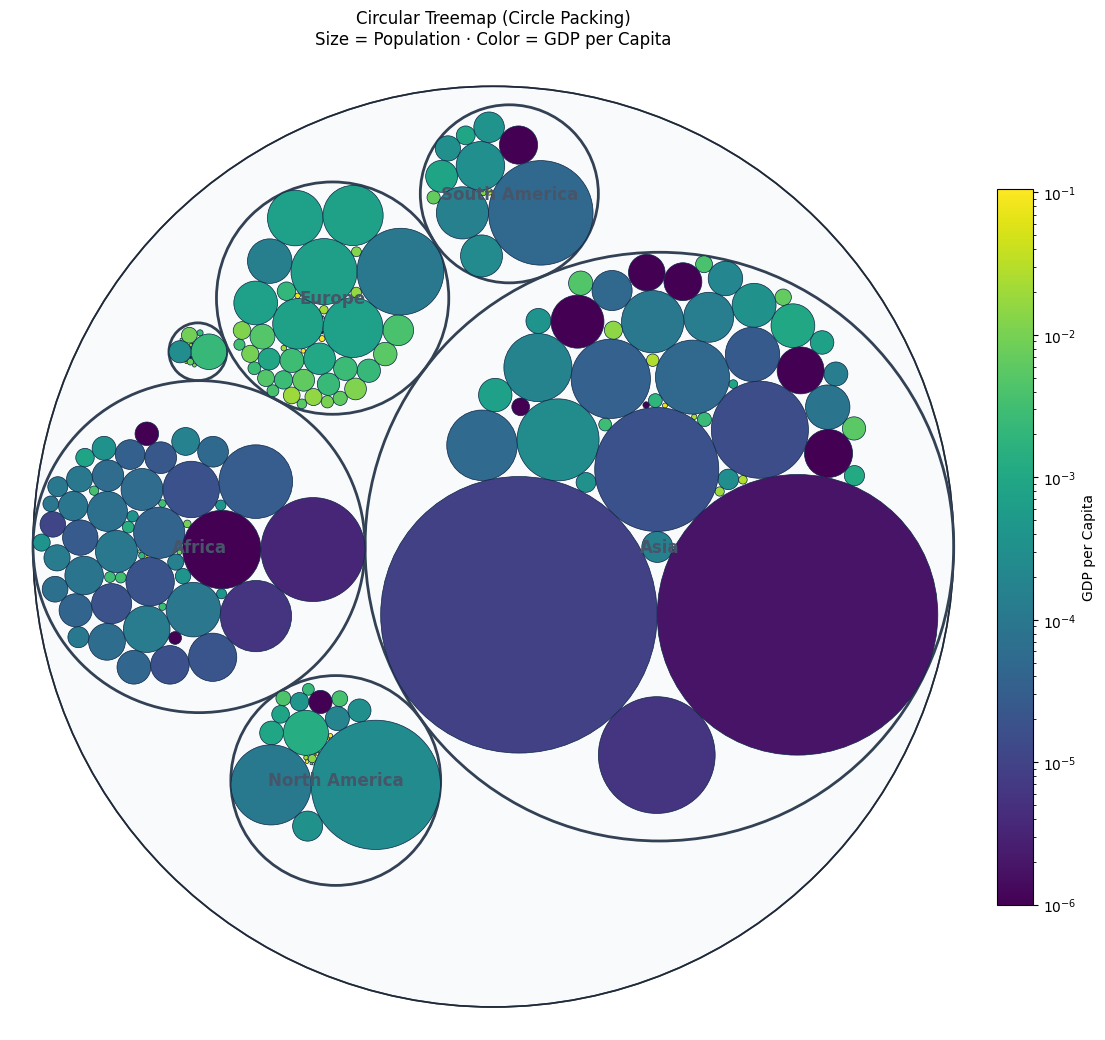

In [ ]:
# --- Circle Packing con color correcto por GDP per Capita ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import circlify

# 1) Cargar dataset
df = pd.read_csv("countries_per_region.csv")

# 2) Limpiar y derivar métrica
df["Population"] = pd.to_numeric(df["Population"], errors="coerce")
df["GDP"] = pd.to_numeric(df["GDP"], errors="coerce")
df = df.dropna(subset=["Population", "GDP", "Continent", "Country_Name"])
df = df[df["Population"] > 0].copy()

# GDP en este CSV es monto total; per cápita = GDP / Population (ya viste que va ~0..1.12)
df["GDP_per_capita"] = df["GDP"] / df["Population"]

# 3) Lookup externo para evitar warnings de circlify (no metemos gdp_pc dentro de la jerarquía)
gdp_pc_lookup = dict(zip(df["Country_Name"], df["GDP_per_capita"]))

# 4) Jerarquía para circlify (usar SOLO 'id' y 'datum' para evitar warnings)
def _sum_pop(cont):
    return float(df.loc[df["Continent"] == cont, "Population"].sum())

hierarchy = [
    dict(
        id="World",
        datum=float(df["Population"].sum()),
        children=[
            dict(
                id=cont,
                datum=_sum_pop(cont),
                children=[
                    dict(
                        id=row["Country_Name"],
                        datum=float(row["Population"]),   # hoja = población
                    )
                    for _, row in df[df["Continent"] == cont].iterrows()
                    if float(row["Population"]) > 0
                ],
            )
            for cont in sorted(df["Continent"].unique())
        ],
    )
]

# 5) Calcular círculos
circles = circlify.circlify(hierarchy, show_enclosure=True)

# 6) Normalización de color (mejor contraste)
#    Usamos una escala LOG con recorte por percentiles para evitar que todo se vea oscuro.
vals = df["GDP_per_capita"].astype(float).replace([np.inf, -np.inf], np.nan)
lo = np.nanpercentile(vals, 5)   # p5
hi = np.nanpercentile(vals, 95)  # p95
vals_clip_min = max(lo, 1e-6)    # evitar cero en LogNorm
vals_clip_max = max(hi, vals_clip_min * 1.01)  # evitar vmax==vmin

norm = mpl.colors.LogNorm(vmin=vals_clip_min, vmax=vals_clip_max)
cmap = mpl.cm.viridis

# 7) Dibujar Circle Packing
fig, ax = plt.subplots(figsize=(11, 11))
ax.set_aspect("equal")
ax.axis("off")

for c in circles:
    x, y, r = c.x, c.y, c.r
    ex = getattr(c, "ex", None)

    # Nivel 0 = círculo de la figura (enclosure externo, sin 'ex')
    if c.level == 0:
        ax.add_patch(plt.Circle((x, y), r, facecolor="#f9fafb", edgecolor="#334155", lw=1.2))
        continue

    # Raíz "World"
    if ex and ex.get("id") == "World":
        ax.add_patch(plt.Circle((x, y), r, facecolor="none", edgecolor="#1f2937", lw=1.2))
        continue

    # Continente (tiene children)
    if ex and ex.get("children") is not None:
        ax.add_patch(plt.Circle((x, y), r, facecolor="none", edgecolor="#334155", lw=2.0))
        name = ex.get("id", "")
        if r > 0.18 and name:  # etiqueta sólo si hay espacio
            ax.text(x, y, name, ha="center", va="center",
                    fontsize=12, color="#475569", weight="bold")
        continue

    # Hoja = país (no tiene children)
    if ex and ex.get("children") is None:
        country = ex.get("id")
        gpc = gdp_pc_lookup.get(country, np.nan)
        # Si falta valor, dale el mínimo para que se vea
        if not np.isfinite(gpc) or gpc <= 0:
            gpc = vals_clip_min
        color = cmap(norm(gpc))
        ax.add_patch(plt.Circle((x, y), r, facecolor=color, edgecolor="#0b2545", lw=0.5))

# 8) Límites para ver todo el círculo
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)

# 9) Barra de color (usa la misma normalización)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label("GDP per Capita", rotation=90)

plt.title("Circular Treemap (Circle Packing)\nSize = Population · Color = GDP per Capita", pad=14)
plt.subplots_adjust(left=0.02, right=0.95, top=0.92, bottom=0.02)
plt.show()

## Comparative Analysis

✅ DataFrame 'df' loaded with shape: (193, 6)


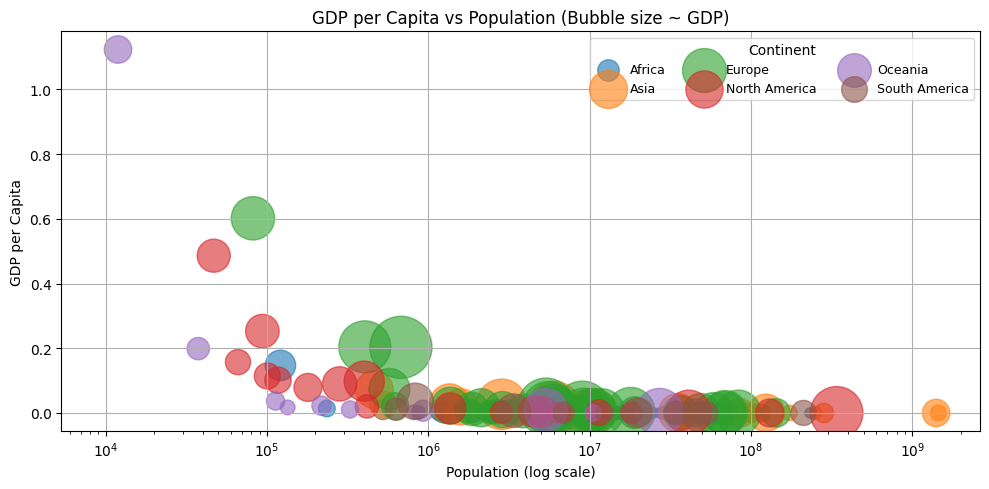

Visualization 1 — Bubble Scatter
a) Best suited for: Exploring relationships and clusters between population size and GDP per capita, with GDP encoded by bubble size.
b) Key insight: High-population countries often concentrate at lower-to-mid GDP per capita, while smaller populations can show very high GDP per capita; regional clusters/outliers emerge by continent.
c) Limitation: Overplotting/overlap may hide small countries; bubble areas make precise reading difficult.


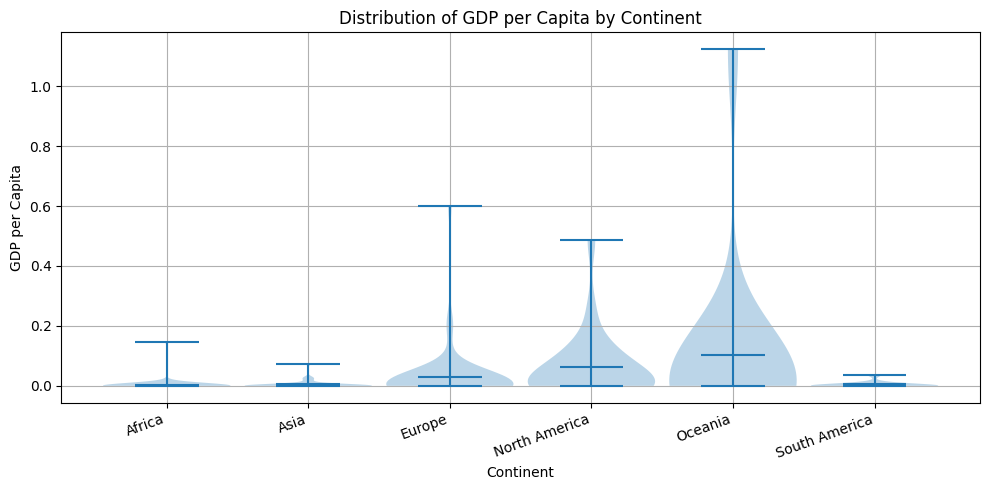

Visualization 2 — Violin Plot
a) Best suited for: Comparing distributional shape, spread, and central tendency across groups (continents).
b) Key insight: Wider violins indicate greater dispersion in GDP per capita (heterogeneous economies), narrower violins suggest more uniformity.
c) Limitation: Country-level detail is abstracted; shapes can be misleading with small sample sizes per continent.


In [ ]:
# Ensure df exists (load dataset if not already in memory)
import pandas as pd
from pathlib import Path

if 'df' not in locals():
    possible_paths = [
        Path('countries_per_region.csv'),
        Path('/mnt/data/countries_per_region.csv'),
        Path('population.csv'),
    ]
    csv_path = next((p for p in possible_paths if p.exists()), None)
    if csv_path is None:
        raise FileNotFoundError("Dataset not found. Place 'countries_per_region.csv' in the same folder.")
    df = pd.read_csv(csv_path)

print("✅ DataFrame 'df' loaded with shape:", df.shape)

import numpy as np
import matplotlib.pyplot as plt

# --- Prep ---
df = df.copy()
df["Population"] = pd.to_numeric(df["Population"], errors="coerce")
df["GDP"] = pd.to_numeric(df["GDP"], errors="coerce")
df = df.dropna(subset=["Country_Name", "Country_Code", "Population", "GDP", "Continent"])
df = df[df["Population"] > 0].copy()
df["GDP_per_capita"] = df["GDP"] / df["Population"]

plt.rcParams.update({"figure.figsize": (10, 5), "axes.grid": True})
continents = sorted(df["Continent"].dropna().unique())

# ============== Visualization 1 — Bubble Scatter ==============
gdp_rel = df["GDP"] / df["GDP"].max()
sizes = (gdp_rel ** 0.7) * 2000

plt.figure()
for cont in continents:
    d = df[df["Continent"] == cont]
    plt.scatter(d["Population"], d["GDP_per_capita"], s=sizes.loc[d.index], alpha=0.6, label=str(cont))
plt.xscale('log')
plt.title("GDP per Capita vs Population (Bubble size ~ GDP)")
plt.xlabel("Population (log scale)")
plt.ylabel("GDP per Capita")
plt.legend(title="Continent", ncol=3, fontsize=9, frameon=True)
plt.tight_layout()
plt.show()

print("Visualization 1 — Bubble Scatter")
print("a) Best suited for:",
      "Exploring relationships and clusters between population size and GDP per capita, with GDP encoded by bubble size.")
print("b) Key insight:",
      "High-population countries often concentrate at lower-to-mid GDP per capita, while smaller populations can show very high GDP per capita; regional clusters/outliers emerge by continent.")
print("c) Limitation:",
      "Overplotting/overlap may hide small countries; bubble areas make precise reading difficult.")

# ============== Visualization 2 — Violin Plot ==============
groups = [df.loc[df["Continent"] == cont, "GDP_per_capita"].dropna().values for cont in continents]
labels = [str(c) for c in continents]

plt.figure()
_ = plt.violinplot(groups, showmeans=True, showextrema=True, widths=0.9)
plt.xticks(np.arange(1, len(labels) + 1), labels, rotation=20, ha='right')
plt.title("Distribution of GDP per Capita by Continent")
plt.xlabel("Continent")
plt.ylabel("GDP per Capita")
plt.tight_layout()
plt.show()

print("Visualization 2 — Violin Plot")
print("a) Best suited for:",
      "Comparing distributional shape, spread, and central tendency across groups (continents).")
print("b) Key insight:",
      "Wider violins indicate greater dispersion in GDP per capita (heterogeneous economies), narrower violins suggest more uniformity.")
print("c) Limitation:",
      "Country-level detail is abstracted; shapes can be misleading with small sample sizes per continent.")
